# TSARNN Homework 8 - Maximilian Rokuss and Julius Meyer-Ohlendorf



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch as tc
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

# **Task 1: Learning Dynamics**

In [3]:
# loading data
location = '/content/drive/MyDrive/Colab Notebooks/TSARNN/TSARNN_Ex8/'
filename = "sinus.pt"

In [4]:
# choosen parameters
input_size = 1
hidden_size = 4
output_size = 1
epochs = 100

data = tc.load(location + filename)

x = tc.FloatTensor(data[:-1])
y = tc.FloatTensor(data[1:])

We adapted the given code snippet in the following way:

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        # define the network modules here

        self.layer11 = nn.Linear(input_size, hidden_size)
        self.layer12 = nn.Linear(hidden_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, inp, hidden):
        # instantiate modules here
  
        hidden = tc.tanh(self.layer11(inp) + self.layer12(hidden))
        output = self.layer2(hidden)

        return output, hidden



def train_us(model, epochs, x, y, optimizer_type, lr, momentum=0.0):
    # deciding which optimizer to use
    if (optimizer_type == 'SGD'):
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif (optimizer_type == 'Adam'):
      optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    for i in range(epochs):
        hidden = tc.zeros((1, hidden_size))
        loss = 0 
        for j in range(x.size(0)):
            input_ = x[j:(j+1)]
            target = y[j:(j+1)]
            (prediction, hidden) = model.forward(input_, hidden)
            loss += (prediction - target).pow(2).sum()/2

            losses.append((prediction - target).pow(2).sum()/2)


        loss.backward(retain_graph=True)  # retain, because of BPTT (next lecture)
        optimizer.step()
        optimizer.zero_grad()
    
    return(losses, model)


def plot_prediction(model, data, x, figsize=(8,8)):
    hidden = tc.zeros((1, hidden_size))
    predictions = []

    inp = x[0:1]
    for i in range(6 * x.size(0)):  # predict for longer time than the training data
        prediction, hidden = model.forward(inp, hidden)
        inp = prediction
        predictions.append(prediction.data.numpy().ravel()[0])

  
    plt.figure(0, figsize=figsize)
    plt.title('Prediction')
    plt.plot(data[1:], label='data')
    plt.plot(predictions, label='predictions')
    plt.legend()
    plt.grid()
    plt.show()


##1.1) SGD without momentum:

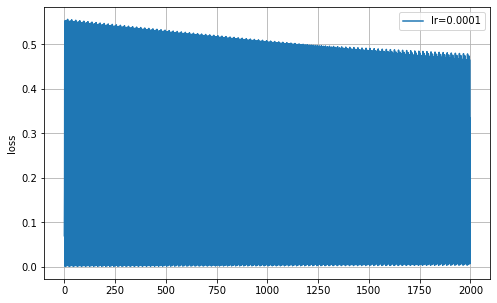

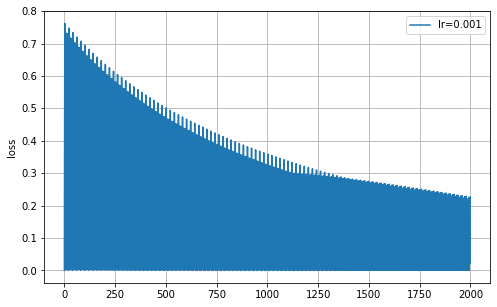

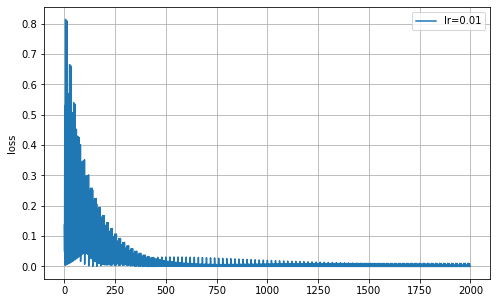

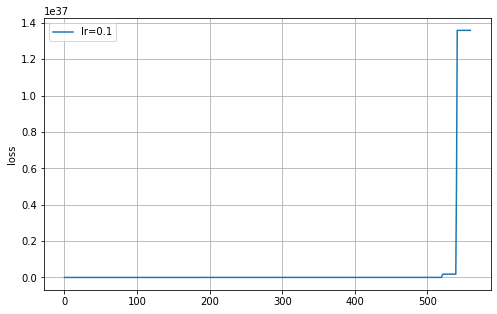

In [8]:
lr_arr = np.array([1e-4, 1e-3, 1e-2, 1e-1])

for i, lr in enumerate(lr_arr):
  model = RNN(input_size, hidden_size, output_size)
  losses, model = train_us(model, epochs, x, y, optimizer_type='SGD', lr=lr, momentum=0.0)

  plt.figure(i, figsize=(8,5))
  plt.plot(losses, label='lr={0}'.format(lr))
  plt.legend()
  plt.grid()
  plt.ylabel('loss')
  plt.show()

For the smallest learning rate lr=0.0001, the loss is only decreasing very slowly. For the largest learning rate lr=0.1, the loss also shows that the nework is not properly being trained. In general the behaviour is expected, as with too small or large learning rates, it is normally not possible to reach a "good" minimum of the loss function. The smoothest loss function is obtained with lr=0.01, which in general in neural network training tasks turned out to be a good choice.

##1.2) SGD with momentum:

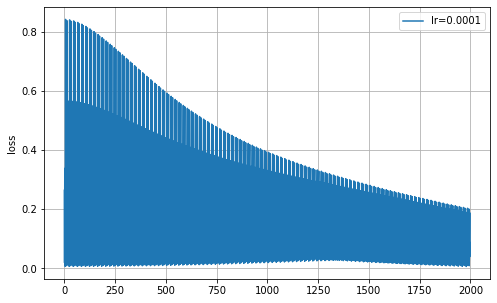

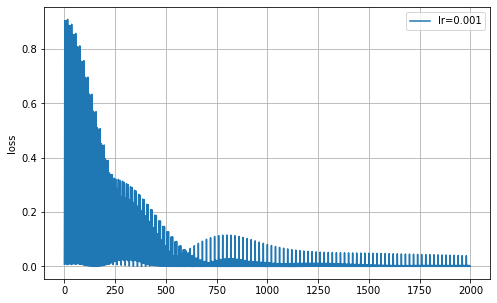

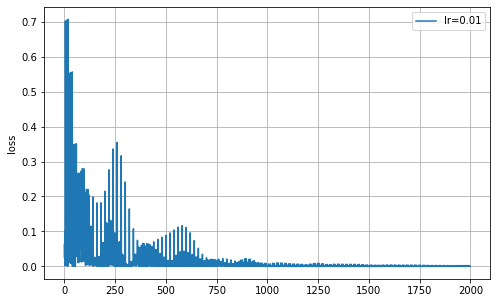

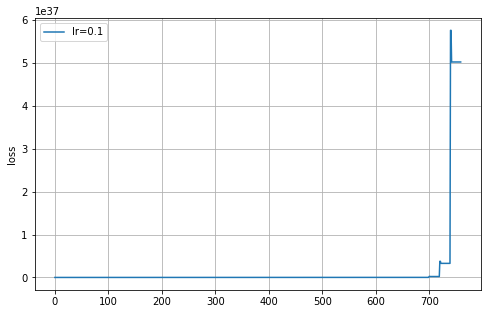

In [ ]:
lr_arr = np.array([1e-4, 1e-3, 1e-2, 1e-1])
epochs = 100 

for i, lr in enumerate(lr_arr):
  model = RNN(input_size, hidden_size, output_size)
  losses, model = train_us(model, epochs, x, y, optimizer_type='SGD', lr=lr, momentum=0.9)

  plt.figure(i, figsize=(8,5))
  plt.plot(losses, label='lr={0}'.format(lr))
  plt.legend()
  plt.grid()
  plt.ylabel('loss')
  plt.show()

A similar result as in the previous task is obtained here. So, momentum does seem to make a huge difference here.

##1.3) Adam:

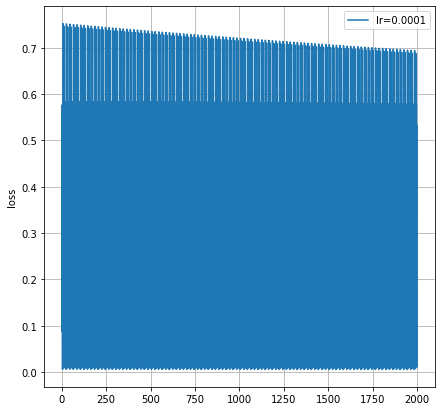

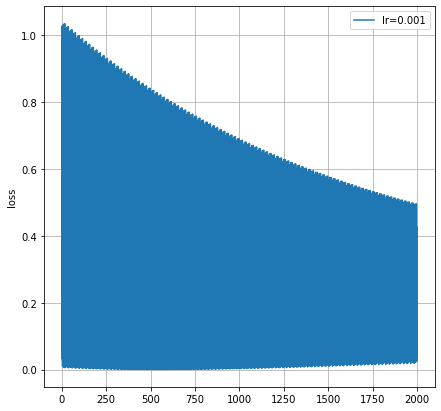

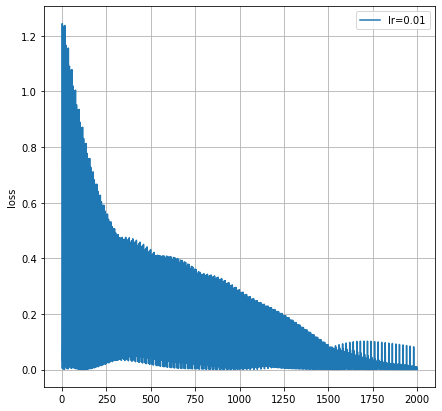

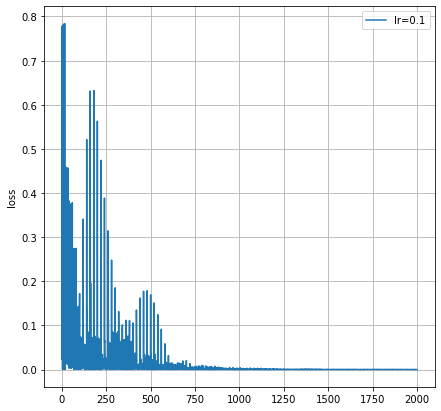

In [ ]:
lr_arr = np.array([1e-4, 1e-3, 1e-2, 1e-1])
epochs = 100

for i, lr in enumerate(lr_arr):
  model = RNN(input_size, hidden_size, output_size)
  losses, model = train_us(model, epochs, x, y, optimizer_type='Adam', lr=lr, momentum=0.0)

  plt.figure(i, figsize=(7,7))
  plt.plot(losses, label='lr={0}'.format(lr))
  plt.legend()
  plt.grid()
  plt.ylabel('loss')
  plt.show()

In general, the results look a bit worse than in the SGD case. We did not expect this, as in fedforward neural networks the Adam optimizer ususally performs very well.

Identifying bifurcations:

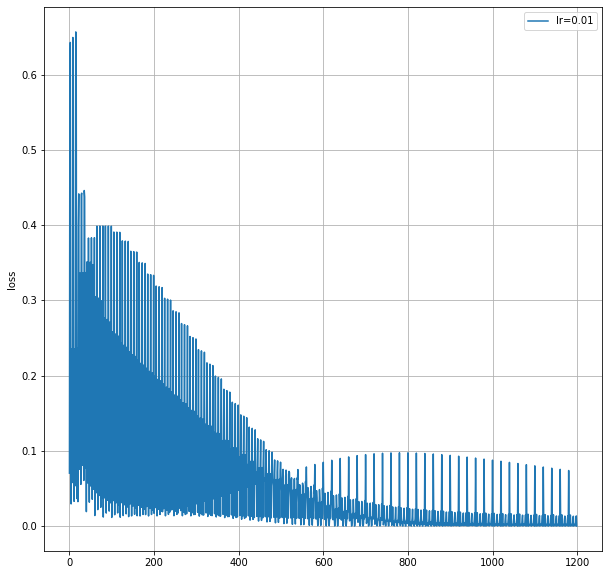

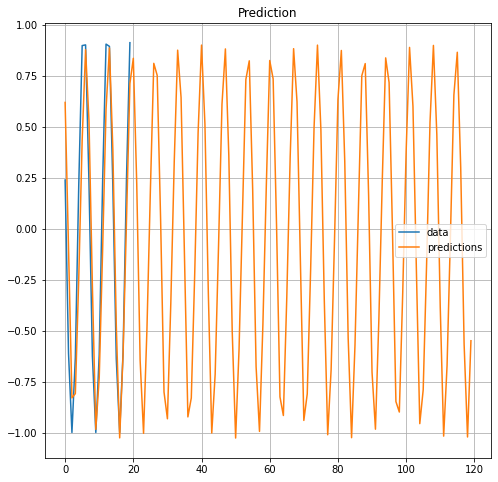

In [20]:
epochs = 60

model = RNN(input_size, hidden_size, output_size)
losses, model = train_us(model, epochs, x, y, optimizer_type='SGD', lr=0.01)

plt.figure(0, figsize=(10,10))
plt.plot(losses, label='lr=0.01')
plt.legend()
plt.grid()
plt.ylabel('loss')
plt.show()

plot_prediction(model, data, x)


Above we can see birfurcations by eye-balling the loss function since it seems to be made up of several different curves on which only appear for the respective input output pair.

Plot of the freely running network for every fourth epoch:

In [ ]:

def train_us_freely(model, epochs, x, y, optimizer_type, lr, momentum=0.0):
  
    # deciding which optimizer to use
    if (optimizer_type == 'SGD'):
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif (optimizer_type == 'Adam'):
      optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    for i in range(epochs):
        hidden = tc.zeros((1, hidden_size))
        loss = 0 
        for j in range(x.size(0)):
            input_ = x[j:(j+1)]
            target = y[j:(j+1)]
            (prediction, hidden) = model.forward(input_, hidden)
            loss += (prediction - target).pow(2).sum()/2

            losses.append((prediction - target).pow(2).sum()/2)


        loss.backward(retain_graph=True)  # retain, because of BPTT (next lecture)
        optimizer.step()
        optimizer.zero_grad()
        if i%4 == 0:
          plot_prediction_freely(model, data, x)
    
    return(losses, model)


def plot_prediction_freely(model, data, x):
    hidden = tc.zeros((1, hidden_size))
    predictions = []

    inp = x[0:1]
    for i in range(6*x.size(0)):  # predict for longer time than the training data
        prediction, hidden = model.forward(inp, hidden)
        inp = prediction
        predictions.append(prediction.data.numpy().ravel()[0])

  
    plt.plot(predictions, "--", label='predictions')
    
        

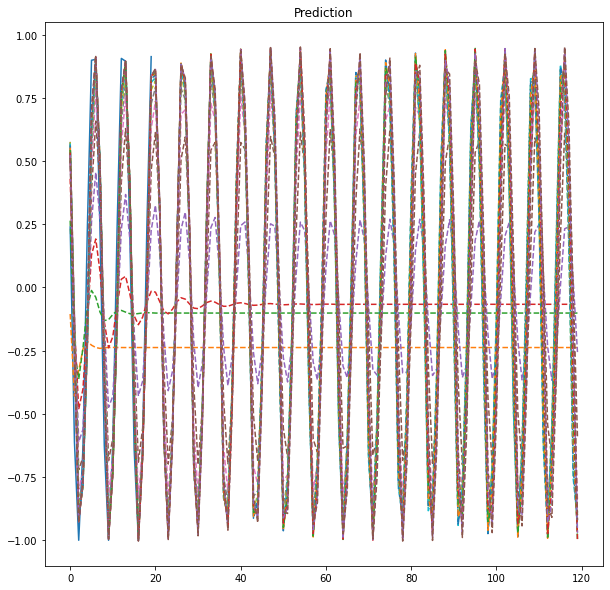

In [ ]:
epochs = 60
model = RNN(input_size, hidden_size, output_size)

plt.figure(0, figsize=(10,10))
plt.title('Prediction')
plt.plot(data[1:], label='data')
losses, model = train_us_freely(model, epochs, x, y, optimizer_type='SGD', lr=0.01)
plt.show()



One can clearly see the prediction improvement of the network during training.

# **Task 2: Resevoir Computing**

### 2.1) Initialize weights Wxz and Wzz

In [ ]:
class RNN_initialized(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initializer):
        super(RNN_initialized, self).__init__()
        # define the network modules here
      
        self.layer11 = nn.Linear(input_size, hidden_size)
        self.layer12 = nn.Linear(hidden_size, hidden_size)
        
        if (initializer == 'normal'):
          tc.nn.init.normal_(self.layer11.weight)
          tc.nn.init.normal_(self.layer12.weight)

        if (initializer == 'uniform'):
          tc.nn.init.uniform_(self.layer11.weight)
          tc.nn.init.uniform_(self.layer12.weight)

        if (initializer == 'orthogonal'):
          tc.nn.init.orthogonal_(self.layer11.weight)
          tc.nn.init.orthogonal_(self.layer12.weight)

        self.layer2 = nn.Linear(hidden_size, output_size)


    def forward(self, inp, hidden):
        # instantiate modules here
  
        hidden = tc.tanh(self.layer11(inp) + self.layer12(hidden))
        output = self.layer2(hidden)

        return output, hidden

i) normal initilization:

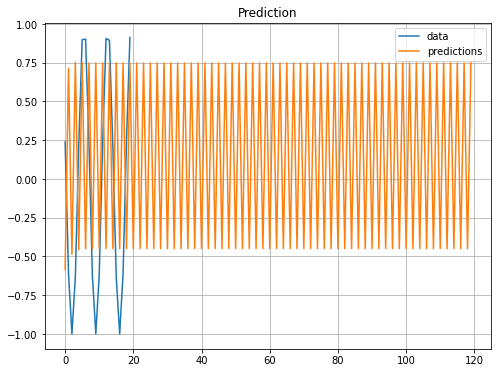

In [ ]:
model_initialized = RNN_initialized(input_size, hidden_size, output_size, 'normal')
plot_prediction(model_initialized, data, x, figsize=(8,6))


ii) uniform initilization:

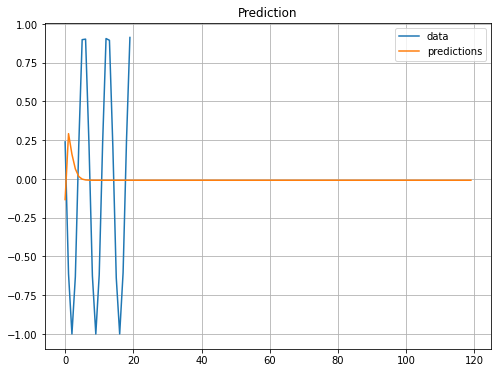

In [ ]:
model_initialized = RNN_initialized(input_size, hidden_size, output_size, 'uniform')
plot_prediction(model_initialized, data, x, figsize=(8,6))


ii) orthogonal initilization:

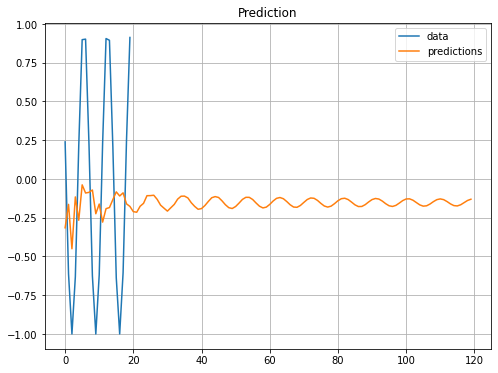

In [ ]:
model_initialized = RNN_initialized(input_size, hidden_size, output_size, 'orthogonal')
plot_prediction(model_initialized, data, x, figsize=(8,6))

As expected, non of the initializations is able to produce satisfying predictions. 

### 2.2) Initialize weights Wxz and Wzz and only train Wzx:

In [ ]:
def train_Wzx(model, epochs, x, y, lr, momentum=0.0):
    # only optimize layer weights Wzx
    optimizer = optim.SGD(model.layer2.parameters(), lr=lr, momentum=momentum)
  
    losses = []
    for i in range(epochs):
        hidden = tc.zeros((1, hidden_size))
        loss = 0 
        for j in range(x.size(0)):
            input_ = x[j:(j+1)]
            target = y[j:(j+1)]
            (prediction, hidden) = model.forward(input_, hidden)
            loss += (prediction - target).pow(2).sum()/2

            losses.append((prediction - target).pow(2).sum()/2)


        loss.backward(retain_graph=True)  # retain, because of BPTT (next lecture)
        optimizer.step()
        optimizer.zero_grad()
    
    return(losses, model)

i) with normal Wxz and Wzz:

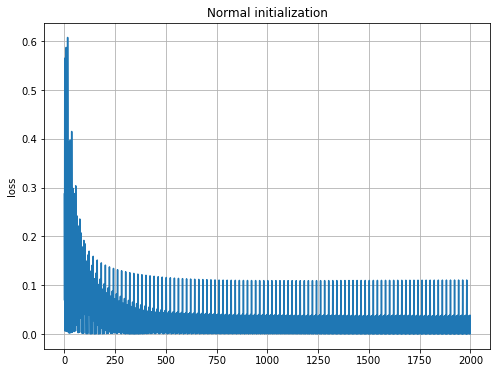

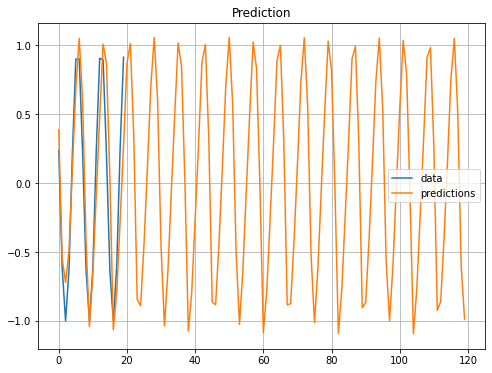

In [ ]:
epochs = 100
model_initialized = RNN_initialized(input_size, hidden_size, output_size, 'normal')

losses, model_initialized = train_Wzx(model_initialized, epochs, x, y, 0.01)

plt.figure(0, figsize=(8,6))
plt.title('Normal initialization')
plt.plot(losses)
plt.ylabel('loss')
plt.grid()
plt.show()

plot_prediction(model_initialized, data, x, figsize=(8,6))

ii) with uniform Wxz and Wzz:

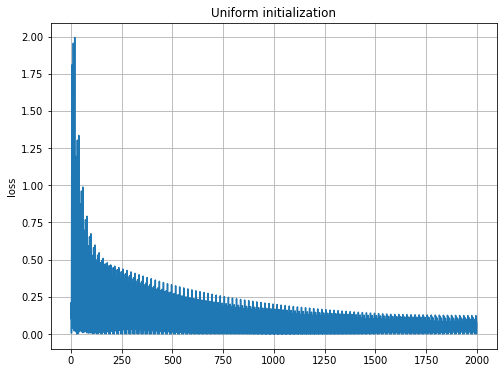

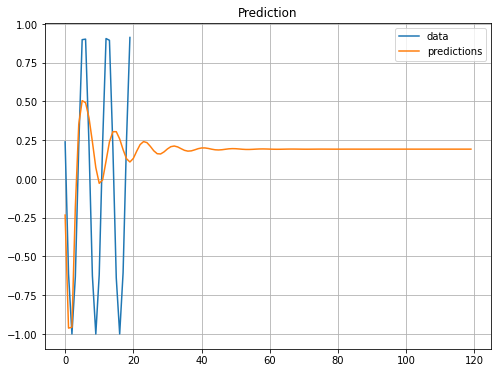

In [ ]:
epochs = 100
model_initialized = RNN_initialized(input_size, hidden_size, output_size, 'uniform')

losses, model_initialized = train_Wzx(model_initialized, epochs, x, y, 0.01)

plt.figure(0, figsize=(8,6))
plt.title('Uniform initialization')
plt.plot(losses)
plt.ylabel('loss')
plt.grid()
plt.show()

plot_prediction(model_initialized, data, x, figsize=(8,6))

iii) with orthogonal Wxz and Wzz:

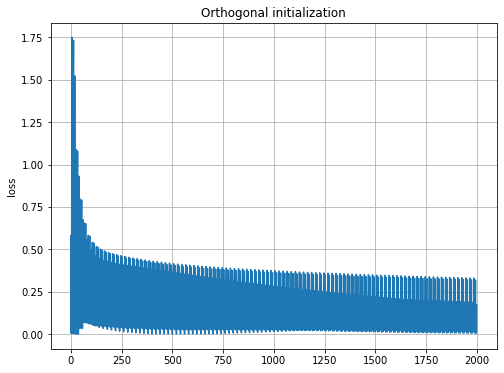

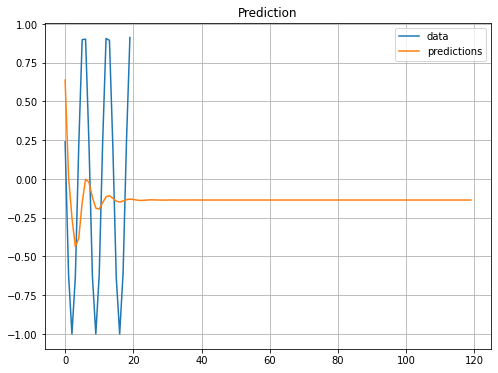

In [ ]:
epochs = 100
model_initialized = RNN_initialized(input_size, hidden_size, output_size, 'orthogonal')

losses, model_initialized = train_Wzx(model_initialized, epochs, x, y, 0.01)

plt.figure(0, figsize=(8,6))
plt.title('Orthogonal initialization')
plt.plot(losses)
plt.ylabel('loss')
plt.grid()
plt.show()

plot_prediction(model_initialized, data, x, figsize=(8,6))

Only the case i) with normal initialized weights of Wxz and Wzz and the following training of the weights Wzx is able to recover the oscillations and produce satisfying results here.


